In [3]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [11]:
import pyhf
import logging
logging.basicConfig(level = logging.INFO)
from pyhf import hfpdf
def prep_data(sourcedata):
    spec =  {
        'signal': {
            'signal': {
                'data': sourcedata['signal']['bindata']['sig'],
                'mods': [
                    {
                        'name': 'mu',
                        'type': 'normfactor',
                        'data': None
                    }
                ]
            },
            'bkg1': {
                'data': sourcedata['signal']['bindata']['bkg1'],
                'mods': [
                    {
                        'name': 'coupled_normsys',
                        'type': 'normsys',
                        'data':  {'lo': 0.9, 'hi': 1.1}
                    }
                ]
            },
            'bkg2': {
                'data': sourcedata['signal']['bindata']['bkg2'],
                'mods': [
                    {
                        'name': 'coupled_normsys',
                        'type': 'normsys',
                        'data':  {'lo': 0.5, 'hi': 1.5}
                    }
                ]
            }
        },
        'control': {
            'background': {
                'data': sourcedata['control']['bindata']['bkg1'],
                'mods': [
                    {
                        'name': 'coupled_normsys',
                        'type': 'normsys',
                        'data': {'lo': 0.9, 'hi': 1.1}
                    }
                ]
            }
        }
    }
    pdf  = hfpdf(spec)
    data = []
    for c in pdf.config.channel_order:
        data += sourcedata[c]['bindata']['data']
    data = data + pdf.auxdata
    return data, pdf

In [12]:
source = {
  "channels": {
    "signal": {
      "binning": [2,-0.5,1.5],
      "bindata": {
        "data":    [105.0, 220.0],
        "bkg1":     [100.0, 100.0],
        "bkg2":     [50.0, 100.0],
        "sig":     [10.0, 35.0]
      }
    },
    "control": {
      "binning": [2,-0.5,1.5],
      "bindata": {
        "data":    [110.0, 105.0],
        "bkg1":     [100.0, 100.0]
      }
    }
  }
}



d,pdf = prep_data(source['channels'])

print (d)

init_pars = pdf.config.suggested_init()
par_bounds = pdf.config.suggested_bounds()

unconpars = pyhf.unconstrained_bestfit(d,pdf,init_pars,par_bounds)
print ('UNCON',unconpars)

conpars = pyhf.constrained_bestfit(0.0,d,pdf,init_pars,par_bounds)
print ('CONS', conpars)

pdf.expected_data(conpars)

INFO:pyhf:adding modifier coupled_normsys (1 new nuisance parameters)
INFO:pyhf:adding modifier mu (1 new nuisance parameters)
INFO:pyhf:accepting existing normsys
INFO:pyhf:accepting existing normsys


[110.0, 105.0, 105.0, 220.0, 0]
('UNCON', array([-0.63019971,  1.3899647 ]))
('CONS', array([-0.03951769,  0.        ]))


array([ 9.95845052e+01,  9.95845052e+01,  1.48233514e+02,  1.96882523e+02,
       -3.95176873e-02])

{'exp': [1.0789267491161063,
  1.4066615840799475,
  1.8827124431834952,
  2.5079457068437514,
  3.221855081876956],
 'obs': 2.603705004111145}

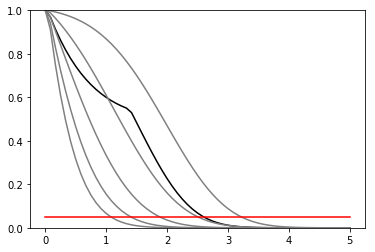

In [13]:
def plot_results(testmus,cls_obs, cls_exp, test_size = 0.05):
    plt.plot(mutests,cls_obs, c = 'k')
    for i,c in zip(range(5),['grey','grey','grey','grey','grey']):
        plt.plot(mutests,cls_exp[i], c = c)
    plt.plot(testmus,[test_size]*len(testmus), c = 'r')
    plt.ylim(0,1)

def CLsOnePoint(muTest,d,pdf, init_pars,par_bounds):
    clsobs, cls_exp = pyhf.runOnePoint(muTest, d,pdf,init_pars,par_bounds)[-2:]
    return 1./clsobs, [1./x for x in cls_exp]

def invert_interval(testmus,cls_obs, cls_exp, test_size = 0.05):
    point05cross = {'exp':[],'obs':None}
    for cls_exp_sigma in cls_exp:
        yvals = [x for x in cls_exp_sigma]
        point05cross['exp'].append(np.interp(test_size,list(reversed(yvals)),list(reversed(testmus))))
        
    yvals = cls_obs
    point05cross['obs'] = np.interp(test_size,list(reversed(yvals)),list(reversed(testmus)))
    return point05cross


CLsOnePoint(1.0,d,pdf,init_pars,par_bounds)


mutests = np.linspace(0,5,61)
tests = [CLsOnePoint(muTest,d,pdf,init_pars,par_bounds) for muTest in mutests]
cls_obs = [test[0]  for test in tests]
cls_exp = [[test[1][i]  for test in tests] for i in range(5)]

plot_results(mutests, cls_obs, cls_exp)

invert_interval(mutests, cls_obs, cls_exp)


